# Network Creation

Let's create a small Neural Network with 3 hidden layers for testing

In [1]:
import numpy as np
import pandas as pd
from nn_utils import *

In [2]:
n_hidden_layers = 3
n_neurons = 5
n_outputs = 3
n_inputs = 10

net = NeuralNetwork()
net.add_input_layer(10)

net.add_hidden_layer(10, 15)
net.add_hidden_layer(15, 14)
net.add_hidden_layer(14, 14)
net.add_output_layer(14, 3)


print(net)
print(net.number_of_nodes())

INPUT LAYER: 
NODE 0 OUTPUT = 0.0
NODE 1 OUTPUT = 0.0
NODE 2 OUTPUT = 0.0
NODE 3 OUTPUT = 0.0
NODE 4 OUTPUT = 0.0
NODE 5 OUTPUT = 0.0
NODE 6 OUTPUT = 0.0
NODE 7 OUTPUT = 0.0
NODE 8 OUTPUT = 0.0
NODE 9 OUTPUT = 0.0

LAYER 0 
NODE 0 WEIGHTS = -0.08481821454237856, -0.031662419026001205, 0.32450258398160775, 0.0925785813096498, -0.3286080994824401, 0.2941023928720536, -0.044274125761900075, -0.20112995512059087, -0.1819614361474789, 0.07729699876070212,  BIAS = 0.0
NODE 1 WEIGHTS = -0.29368210204624984, -0.13378140871907826, 0.2117698110589525, 0.3622381492203806, 0.2226279681027196, -0.2668957675585814, 0.023145949364723542, 0.26039415367243524, 0.1397492583972467, -0.013067340137494237,  BIAS = 0.0
NODE 2 WEIGHTS = -0.38243752881412646, -0.5358077452300491, -0.11067521911640157, -0.5960770712169666, 0.06968196727098575, 0.16057733941346278, -0.08352231585006588, 0.1558470998707922, -0.15375825131370116, -0.033691445995478186,  BIAS = 0.0
NODE 3 WEIGHTS = -0.31681452787804815, -0.0680583

In [3]:
col_names = ('Input1', 'Input2', 'Input3', 'Input4', 'Input5', 'Input6',
             'Input7', 'Input8', 'Input9', 'Input10', 'TARGET_x', 'TARGET_y', 'TARGET_z')
data = pd.read_csv("../ML-23-PRJ-Package/ML-CUP23-TR.csv",
                   skiprows=7, usecols=[i for i in range(1, 14)], names=col_names)

data

,Input1,Input2,Input3,Input4,Input5,Input6,Input7,Input8,Input9,Input10,TARGET_x,TARGET_y,TARGET_z
0,-0.917280,-0.712727,-0.989904,0.992819,0.993649,0.995543,0.711074,0.407645,-0.688548,0.616890,7.897453,-35.936382,21.077147
1,-0.858784,0.998755,-0.998396,0.999909,0.316503,-0.951897,-0.163139,0.980982,0.661759,-0.800155,-9.330632,19.901571,6.069154
2,-0.990441,0.958726,-0.998675,0.997216,0.987166,0.356483,-0.279689,0.599163,-0.684630,0.922901,14.849400,3.374090,19.667479
3,0.937117,0.984474,-0.612420,0.999812,0.728623,-0.539962,-0.165939,0.999352,-0.921444,-0.974766,-46.591854,13.734777,17.953600
4,-0.906628,-0.884567,-0.932487,0.941037,0.978134,0.998179,0.749606,-0.590599,-0.508268,0.691798,8.217500,-45.885254,14.894251
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-0.803560,-0.878859,-0.978391,0.957539,0.996655,0.996924,-0.226305,0.097814,-0.922666,0.934153,15.389553,-41.068806,27.513502
996,0.718841,0.995748,-0.942678,0.999929,0.747763,-0.808726,0.176132,0.999100,-0.753970,-0.969009,-36.228770,13.067430,11.672133
997,-0.977912,-0.971108,0.956233,-0.979524,0.222033,0.986609,0.658273,-0.987310,0.937697,0.143420,7.265506,-53.497242,2.815666
998,0.284803,-0.988684,-0.427197,0.883317,0.993302,0.999500,-0.019456,-0.648110,-0.955231,0.901298,5.545274,-63.348396,27.989340



# Preparing Dataframe
i.e. creating the training set by removing non-training columns


In [4]:
# shuffle data
data = data.sample(frac=1)

In [5]:
data[:100]

,Input1,Input2,Input3,Input4,Input5,Input6,Input7,Input8,Input9,Input10,TARGET_x,TARGET_y,TARGET_z
505,-0.783141,0.982899,-0.991131,0.999544,0.979104,0.245720,-0.684849,0.989598,-0.878952,-0.408031,-1.236017,12.417650,31.262812
77,-0.755595,0.992733,-0.995577,0.999917,0.976810,-0.065801,0.269007,0.993817,-0.557701,-0.881794,-12.891227,8.568347,18.459595
942,0.992841,-0.937372,0.977161,-0.979904,0.625473,0.980537,-0.678899,0.942305,-0.140035,-0.977208,-46.324017,-36.192070,22.698689
879,-0.990091,0.994407,-0.999295,0.999448,0.772150,-0.837874,0.159306,0.688084,0.440972,0.722264,7.886519,10.047298,7.455922
417,0.932423,-0.987471,0.526798,0.834493,0.995633,0.999577,-0.169027,-0.017315,-0.973798,0.660503,-7.571103,-70.921370,34.850964
...,...,...,...,...,...,...,...,...,...,...,...,...,...
541,-0.965649,0.965565,-0.997287,0.999480,0.991987,0.549846,-0.027142,0.945286,-0.802153,0.285058,6.844330,4.582930,25.165846
592,0.447516,-0.988584,0.960534,-0.992551,0.580372,0.970793,0.292289,-0.876123,0.923203,-0.815518,-16.746450,-51.307938,9.867192
888,0.925210,-0.971220,0.016550,0.877405,0.996666,0.999490,-0.268883,0.579653,-0.925110,0.109042,-16.430376,-57.985630,34.992752
514,0.944534,-0.982641,0.447105,0.823039,0.996177,0.999560,-0.179152,0.282267,-0.955041,0.393643,-13.162647,-66.551070,34.952780


total Error pre-training = 1142.312304488575


Epoch = 1, total Error post-training = 1123.474925094695
Epoch = 2, total Error post-training = 1080.3449497306844
Epoch = 3, total Error post-training = 988.8618358250254
Epoch = 4, total Error post-training = 844.7813697876521
Epoch = 5, total Error post-training = 718.7190793380686
Epoch = 6, total Error post-training = 623.2827072005871
Epoch = 7, total Error post-training = 650.2672261986137
Epoch = 8, total Error post-training = 575.6761816819234
Epoch = 9, total Error post-training = 490.7812415382807
Epoch = 10, total Error post-training = 465.7539610830233
Epoch = 11, total Error post-training = 407.2642319393126
Epoch = 12, total Error post-training = 434.5476857316179
Epoch = 13, total Error post-training = 352.873627728607
Epoch = 14, total Error post-training = 417.1803089696066
Epoch = 15, total Error post-training = 311.32637226228775
Epoch = 16, total Error post-training = 404.829296064578
Epoch = 17, total Error post-training = 283.0712578050564
Epoch = 18, total Error

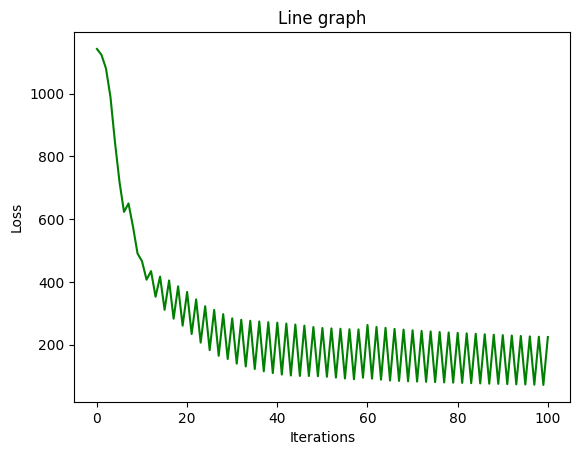

In [6]:
tr_data_X = data[['Input1', 'Input2', 'Input3', 'Input4',
                  'Input5', 'Input6', 'Input7', 'Input8', 'Input9', 'Input10']]

tr_data_Y = data[['TARGET_x', 'TARGET_y', 'TARGET_z']]

# act_fun possible values: "relu", "leaky_relu", "tanh", "sigmoid"

losses = net.train(tr_data_X, tr_data_Y, epochs=100,
                 eta=0.01, clip_value=10000, hid_act_fun="relu", out_act_fun = "linear", cost_fun="mse")
#print(net)
#print(net.input_layer.weights)

plot_loss(losses)


In [7]:
np.dot(net.hidden_layers[0].output, net.hidden_layers[1].weights)

array([ 0.92386893,  4.65036814,  3.4656541 , -1.94489014, -0.89784559,
        2.0892068 , -3.33149471,  1.84034483, -2.72281213, -3.45746103,
        2.85937109, -0.78413409,  0.13635383,  4.28649052])

In [8]:
net.output_layer.output

array([  8.03963634, -13.69481415,  18.51180373])

In [9]:
for row, label in zip(tr_data_X.itertuples(index=False, name=None), tr_data_Y.itertuples(index=False, name=None)):
    # Forward propagation
    net.forwardPropagation( row, label, hid_act_fun = "relu")
    print(np.array(label))
    print(net.output_layer.output)
    break

TypeError: NeuralNetwork.forwardPropagation() missing 2 required positional arguments: 'out_act_fun' and 'cost_fun'

In [ ]:
a = np.array([10, -3])

In [ ]:
def leaky_relu(x, alpha=0.01):
    return np.where(x > 0, x, alpha * x)

In [ ]:
leaky_relu(a)

array([10.  , -0.03])

In [ ]:
def clip_gradients(gradients, clip_value):
    clipped_gradients = []
    for gradient in gradients:
        clipped_gradient = np.clip(gradient, -clip_value, clip_value)
        clipped_gradients.append(clipped_gradient)
    return clipped_gradients

In [ ]:
data[:100]

,Input1,Input2,Input3,Input4,Input5,Input6,Input7,Input8,Input9,Input10,TARGET_x,TARGET_y,TARGET_z
877,0.972025,0.410580,0.375335,0.981677,0.821849,0.976445,0.370172,0.997125,-0.801826,-0.990364,-55.809105,-10.995221,23.190393
596,-0.921641,0.996916,-0.996585,0.999201,0.695600,-0.827381,-0.859343,0.962592,-0.283151,0.088003,4.885140,23.510721,25.254839
785,-0.945496,-0.849870,-0.982610,0.845478,0.989746,0.995534,-0.132807,-0.595489,-0.749627,0.967288,17.255964,-43.981915,21.283264
299,-0.847125,0.958732,-0.992248,0.999134,0.991583,0.658474,-0.571817,0.979084,-0.912930,-0.018332,3.743294,7.814204,32.018210
341,-0.752110,-0.981380,0.628611,0.186702,0.973617,0.999561,0.796431,-0.953215,-0.696914,0.831464,7.501262,-64.925200,9.403218
...,...,...,...,...,...,...,...,...,...,...,...,...,...
666,0.906358,-0.981578,0.049691,0.899411,0.996555,0.999568,-0.161929,0.234609,-0.957945,0.554906,-7.748474,-64.517270,34.682960
444,0.611861,-0.983134,0.971809,-0.993658,-0.081964,0.903549,0.767277,-0.646714,0.932248,-0.942574,-24.396614,-44.692210,3.768535
247,0.727043,0.993637,-0.933711,0.999906,0.842716,-0.688792,-0.382051,0.999030,-0.851263,-0.955829,-35.623497,15.541903,18.137384
340,-0.995151,0.992387,-0.999513,0.999562,0.784210,-0.811411,0.656836,0.317082,0.613851,0.812395,7.300842,5.234912,0.986290
